# Coursework 2 for Cardiac MR Image Segmentation (2020-2021)

After you have gone through the coursework description, this tutorial is designed to further helps you understand the problem and therefore enable you to propose a good solution for this coursework. You will learn:

* how to load and save images with OpenCV
* how to train a segmentation model with Pytorch
* how to evaluate the trained model

In [1]:
import os

In [2]:
# Experiment tracking
import wandb
wandb.login(key="6b1f767abf991bfae730a6a69383da2f716d617c")
wandb.init(project="nc-task2")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: WARNING Calling wandb.login() without arguments from jupyter should prompt you for an api key.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\aleks/.netrc


W&B Run: https://app.wandb.ai/aleksandrs-krivickis-gmail-com/nc-task2/runs/w63yt51f

## 1. Load, show, and save images with OpenCV

OpenCV is an open-source computer vision library which helps us to manipulate image data. In this section, we will cover:
* Loading an image from file with imread()
* Displaying the image with matplotlib plt.imshow()
* Saving an image with imwrite()

For a more comprehensive study of OpenCV, we encourage you to check the official [OpenCV documentation](https://docs.opencv.org/master/index.html).

In [3]:
import torch 
torch.cuda.is_available()

False

In [4]:
from matplotlib import pyplot as plt
def show_image_mask(img, mask, cmap='gray'): # visualisation
    fig = plt.figure(figsize=(5,5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap=cmap)
    plt.axis('off')

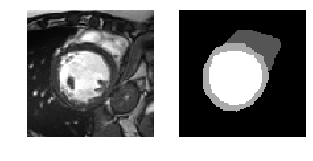

True

In [5]:
import os
import cv2 #import OpenCV

data_dir = './data/train'
image = cv2.imread(os.path.join(data_dir,'image','cmr1.png'), cv2.IMREAD_UNCHANGED)
mask = cv2.imread(os.path.join(data_dir,'mask','cmr1_mask.png'), cv2.IMREAD_UNCHANGED)
show_image_mask(image, mask, cmap='gray')
plt.pause(1)
cv2.imwrite(os.path.join('./','cmr1.png'), mask*85)

Note: You will no doubt notice that the mask images appear to be completely black with no sign of any segmentations. This is because the max intensity of pixels in an 8-bit png image is 255 and your image viewer software only sees 255 as white. For those values close to zero, you will only see dark values. This is the case for our masks as the background, the right ventricle, the myocardium, and the left ventricle in each image are 0, 1, 2, and 3, respectively. All of which are close to zero. If we multiply the original mask by 85 and save the result to the directory where this code is, we can see the heart indeed shows up. 

## 2 Define a segmentation model with Pytorch

In this section, we expect you to learn how to:
* Define a Segmentation Model
* Define a DataLoader that inputs images to the Model
* Define training parameters and train the model
* Test the trained model with a new input image

### 2.1 Define a DataLoader

Below we provide you with a dataloader to use in your assigment. You will only need to focus on the development of your model and loss function.

In [6]:
import torch
import torch.utils.data as data
import cv2
import os
from glob import glob

class TrainDataset(data.Dataset):
    def __init__(self, root=''):
        super(TrainDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))
        self.mask_files = []
        for img_path in self.img_files:
            basename = os.path.basename(img_path)
            self.mask_files.append(os.path.join(root,'mask',basename[:-4]+'_mask.png'))
            

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            label = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float(), torch.from_numpy(label).float()

    def __len__(self):
        return len(self.img_files)

class TestDataset(data.Dataset):
    def __init__(self, root=''):
        super(TestDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))

    def __getitem__(self, index):
            img_path = self.img_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float()

    def __len__(self):
        return len(self.img_files)

### 2.2 Define a Segmentation Model

You will need to define your CNN model for segmentation below

Example tensor size outputs, how PyTorch reads them, and where you encounter them in the wild. 
Note: the values below are only examples. Focus on the rank of the tensor (how many dimensions it has).
    torch.Size([32])
    # 1d: [batch_size] 
    # use for target labels or predictions.
    torch.Size([12, 256])
    # 2d: [batch_size, num_features (aka: C * H * W)]
    # use for nn.Linear() input.
    torch.Size([10, 1, 2048])
    # 3d: [batch_size, channels, num_features (aka: H * W)]
    # when used as nn.Conv1d() input.
    # (but [seq_len, batch_size, num_features]
    # if feeding an RNN).
    torch.Size([16, 3, 28, 28])
    # 4d: [batch_size, channels, height, width]
    # use for nn.Conv2d() input.
    torch.Size([32, 1, 5, 15, 15])
    # 5D: [batch_size, channels, depth, height, width]
    # use for nn.Conv3d() input.
    
Example of convolutional network (FCN AlexNet)

    https://github.com/guilhermesantos/Semantic-Image-Segmentation/blob/master/original_fcn_alexnet.py
    https://github.com/guilhermesantos/Semantic-Image-Segmentation/blob/master/AlexNet-1.png

From assignment document
```
    # Regardless of which network you use, in
    # this task the input tensor to the network must be of size (B, 1, H, W) and the output
    # tensor from the network must be of size (B, 4, H, W). Here B denotes batch size, H
    # and W stand for image height and width, respectively.    
```

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import collections


class UNet(nn.Module):

    def __init__(self, in_channels=1, out_channels=4, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )
        self.out_activation = nn.Softmax((out_channels,4))
       
    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            collections.OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

model = UNet()
print(model)

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [8]:
# #Loading the model
# model.load_state_dict(torch.load("./models/2020-14-12-22-14-05_epoch_50_model.torch"))
# model.eval()

#### 2.2.1 Integration testing of forward pass 

In [9]:
batch_size = 1
# Inputs should be this way [batch_size, channels, height, width]
X_train = image.reshape(batch_size, -1, 96, 96)
X_train = torch.from_numpy(X_train).float()
out = model(X_train)

In [10]:
out[0][0].shape

torch.Size([96, 96])

In [11]:
out.shape

torch.Size([1, 4, 96, 96])

#### 2.2.2 Converting 4 channel output to the image

##### Answer to our question from microsoft teams
    
```The output channel does indeed have 4 channels, one for each class in the mask (0,1,2,3). Each of these channels contains the probabilities for each pixel that it should be classified with the corresponding class. I.e channel 1 corresponds to class 0, channel 2 to class 1... To convert this to a 96*96 image, we need to assign each pixel to the class which the network predicts it belongs to with the highest probability. We do this by finding the maximum probability across the 4 channels, and then assigning it to that class. We can do this using the torch.argmax function as follows: mask_image = torch.argmax(predicted_mask.squeeze(), dim=0). I would strongly recommend you read up on the documentation found here https://pytorch.org/docs/stable/generated/torch.argmax.html```

In [12]:
y_pred = torch.argmax(out.squeeze(), dim=0)

In [13]:
y_pred.shape

torch.Size([96, 96])

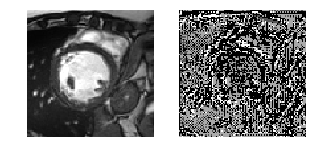

In [14]:
show_image_mask(image, y_pred, cmap='gray')
plt.pause(1)

In [15]:
#Obviously, the outputs represent the noise

### 2.3 Define a Loss function and optimizer

You will need to define a loss function and an optimizer. torch.nn has a variety of readymade loss functions, although you may wish to create your own instead. torch.optim has a variety of optimizers, it is advised that you use one of these.    

In [16]:
# !pip install torchgeometry
from torchgeometry.losses import dice

In [17]:
from torch import optim

loss_fn = dice.DiceLoss()
# loss_fn = nn.CrossEntropyLoss()#nn.MultiLabelSoftMarginLoss()#nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.AdamW(model.parameters(), lr=.001)

steps = 1000
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, steps)

#### 2.3.1 Testing loss function
The input matrix is in the shape: (Minibatch, Classes, H, W). The target matrix is in the shape (Minibatch, H, W) with numbers ranging from 0 to (Classes-1)

In [18]:
# Let's assume that the same mask is pred and test, loss should give us output of 0

y_pred = out#torch.from_numpy(mask).float()
y_test = torch.from_numpy(mask.reshape(-1, 96, 96)).long()
loss_fn(y_pred, y_test)

tensor(0.7460, grad_fn=<MeanBackward0>)

### 2.4 Training

As most of you will use CPUs to train the model, expect your models to take **30 minutes to train if not longer depending on network architecture**. To save time, you should not be using all training data until your model is well developed. If you are running your model on a GPU training should be significantly faster. During the training process, you may want to save the checkpoints as follows:

```
# Saving checkpoints for validation/testing
torch.save(model.state_dict(), path)
```
The saved checkpoints can be used to load at a later date for validation and testing. Here we give some example code for training a model. Note that you need to specify the max iterations you want to train the model.

In [19]:
import numpy 
np = numpy 

def show_image_mask_pred_mask(img, mask, pred_mask, cmap='gray'): # visualisation
    fig = plt.figure(figsize=(5,5))
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap=cmap)
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap=cmap)
    plt.axis('off')    
    
def categorical_dice(mask1, mask2, label_class=1):
    """
    Dice score of a specified class between two volumes of label masks.
    (classes are encoded but by label class number not one-hot )
    Note: stacks of 2D slices are considered volumes.

    Args:
        mask1: N label masks, numpy array shaped (H, W, N)
        mask2: N label masks, numpy array shaped (H, W, N)
        label_class: the class over which to calculate dice scores

    Returns:
        volume_dice
    """
    mask1_pos = (mask1 == label_class).astype(np.float32)
    mask2_pos = (mask2 == label_class).astype(np.float32)
    dice = 2 * np.sum(mask1_pos * mask2_pos) / (np.sum(mask1_pos) + np.sum(mask2_pos))
    return dice    

np = numpy 

def multiclass_categorical_dice(p_tensor_y_true, p_tensor_y_pred):
    
    p_ndarr_y_true = p_tensor_y_true.detach().numpy()
    p_ndarr_y_pred = torch.argmax(p_tensor_y_pred, dim=1).detach().numpy()
    
    accuracy_0 = categorical_dice(p_ndarr_y_true, p_ndarr_y_pred, label_class=0)
    accuracy_1 = categorical_dice(p_ndarr_y_true, p_ndarr_y_pred, label_class=1)
    accuracy_2 = categorical_dice(p_ndarr_y_true, p_ndarr_y_pred, label_class=2)
    accuracy_3 = categorical_dice(p_ndarr_y_true, p_ndarr_y_pred, label_class=3)
    
    return ((accuracy_1 + accuracy_2 + accuracy_3) / 3)

def get_val_score(p_torch_model, p_str_data_path='./data/val', p_int_num_workers=0, p_int_batch_size=2):
    test_set = TrainDataset(p_str_data_path)
    test_data_loader = DataLoader(dataset=test_set, num_workers=p_int_num_workers, batch_size=p_int_batch_size, shuffle=False)
    batch_accuracy = 0
    for iteration, sample in enumerate(test_data_loader):
        img, mask = sample

        outputs = p_torch_model(img.reshape(p_int_batch_size, -1, 96, 96))
        batch_accuracy += multiclass_categorical_dice(p_tensor_y_true=mask, p_tensor_y_pred=outputs)

    batch_accuracy = batch_accuracy / len(test_data_loader)
    return batch_accuracy

# Data Augmentation

In [20]:
from torch.utils.data import DataLoader
import tqdm 
from datetime import datetime
from torchvision import transforms

In [21]:
transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(size=(96, 96), scale=(0.5, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2),
    transforms.RandomRotation((-180, 180), resample = False, expand = False),
    transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomErasing(p=.1, scale=(0.02, 0.09), ratio=(0.3, 3.3)),
        transforms.ToPILImage(),
    ]),
    transforms.RandomHorizontalFlip(p=.2),
])

import random
import torch

def perform_random_transformation(p_np_img, p_np_mask):
    torch_seed = random.randint(-0x8000_0000_0000_0000, 0xffff_ffff_ffff_ffff)   
    np_seed = random.randint(0, 2**32 - 1)
    torch.manual_seed(torch_seed)
    np.random.seed(np_seed)
    img = transform_train(p_np_img)
    torch.manual_seed(torch_seed)  
    np.random.seed(np_seed)
    mask = transform_train(p_np_mask)
    return np.array(img), np.array(mask)

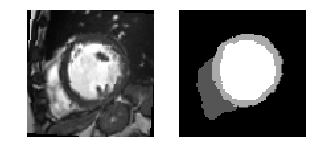

In [22]:
im, msk = perform_random_transformation(p_np_img=image, p_np_mask=mask)
show_image_mask(im, msk, cmap='gray')

In [23]:
data_path = './data/train'
num_workers = 0# Fix of "RuntimeError: DataLoader worker (pid(s) 16856, 2232, 2920, 15672) exited unexpectedly" issue. Previous value - 4
batch_size = 10
train_set = TrainDataset(data_path)
training_data_loader = DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)
num_epochs = 1000

# Experiment tracking


In [24]:
wandb.config.model_configuration = str(model)
wandb.config.loss_function = str(loss_fn).replace("()", "")
wandb.config.optimiser = str(optimizer).split()[0]
wandb.config.optimiser_lr = optimizer.defaults["lr"]
wandb.config.optimiser_momentum = optimizer.defaults.get("momentum", None)
wandb.config.optimiser_dampening = optimizer.defaults.get("dampening", None)
wandb.config.optimiser_weight_decay = optimizer.defaults.get("weight_decay", None)
wandb.config.optimiser_nesterov = optimizer.defaults.get("nesterov", None)
wandb.config.batch_size = batch_size
wandb.config.num_epochs = num_epochs
wandb.config.experimentator_name = str.lower(input(prompt="Please enter your name for experiment tracking purposes."))

wandb.watch(model, criterion=loss_fn, log="all")

wandb: Wandb version 0.10.12 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Please enter your name for experiment tracking purposes. alex


In [25]:
import copy

In [26]:
# model.load_state_dict(torch.load("./models/2020-20-18-08-20-54_epoch_800_model.torch"))
# model.eval()

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\transforms\functional.py:88: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.int32, copy=False))
wandb: Wandb version 0.10.12 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


>>> 12:05:15, Epoch 1/1000, Learning Rate: 0.0009997532801828656, Loss: 0.717, Accuracy: 0.268, Validation Accuracy:  0.305


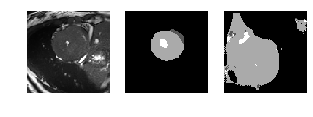

>>> 12:05:54, Epoch 2/1000, Learning Rate: 0.0009990133642141356, Loss: 0.691, Accuracy: 0.432, Validation Accuracy:  0.395


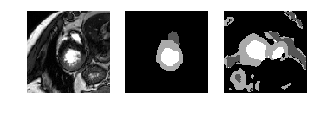

>>> 12:06:27, Epoch 3/1000, Learning Rate: 0.0009977809823015393, Loss: 0.676, Accuracy: 0.527, Validation Accuracy:  0.438


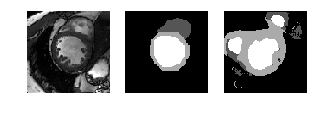

In [ ]:
if len(train_set) % batch_size > 0:
    raise Exception("Incorrect batch size. It has to take into account length of the train dataset.")

for epoch in range(num_epochs):
    running_loss = 0.0
    batch_accuracy = 0
    for iteration, sample in enumerate(training_data_loader):
        img, mask = sample
        
        #Augmenting batch of images
        img_transformed, mask_transformed = [], []
        for one_img, one_mask in zip(img, mask):
            im, msk = perform_random_transformation(p_np_img=one_img.int(), p_np_mask=one_mask.int())
            img_transformed.append(copy.deepcopy(im))
            mask_transformed.append(copy.deepcopy(msk))
            
        img_augmented = torch.from_numpy(np.array(img_transformed)).float()
        mask_augmented = torch.from_numpy(np.array(mask_transformed)).float()
    
        optimizer.zero_grad()
        outputs = model(img_augmented.reshape(batch_size, -1, 96, 96))
        
        loss = loss_fn(outputs, mask_augmented.long())
        loss.backward()
        optimizer.step()   
        scheduler.step()   
        
        running_loss += loss.item()
        batch_accuracy += multiclass_categorical_dice(p_tensor_y_true=mask_augmented, p_tensor_y_pred=outputs)
    val_accuracy = get_val_score(p_torch_model=model, p_str_data_path='./data/val', p_int_num_workers=0, p_int_batch_size=batch_size)
    print(">>> {}, Epoch {}/{}, Learning Rate: {}, Loss: {:.3f}, Accuracy: {:.3f}, Validation Accuracy: {: .3f}".format(datetime.now().strftime("%H:%M:%S"), epoch+1,num_epochs, scheduler.get_last_lr()[0], running_loss/len(training_data_loader), batch_accuracy/batch_size, val_accuracy))
    wandb.log({"epoch": epoch+1, "loss": running_loss/len(training_data_loader), "accuracy": batch_accuracy/batch_size, "val_accuracy": val_accuracy, "learning_rate": scheduler.get_last_lr()[0]})
    #Save model every 50th epoch
    if epoch % 50 == 0:
        os.makedirs(name="./models/", exist_ok=True)
        torch.save(model.state_dict(), "./models/" + datetime.now().strftime("%Y-%M-%d-%H-%M-%S_epoch_") + str(epoch) + "_model.torch")        

    show_image_mask_pred_mask(img[0,...].squeeze(), mask[0,...].squeeze(), torch.argmax(outputs[0,...].squeeze(), dim=0).float())
    plt.pause(1)

In [ ]:
# # Saving checkpoints for validation/testing

# !mkdir models
# torch.save(model.state_dict(), "./models/model.torch")

### 2.5 Testing

When validating the trained checkpoints (models), remember to change the model status as **Evaluation Mode**

In [25]:
import numpy as np
from torch.autograd import Variable

In [26]:
# In this block you are expected to write code to load saved model and deploy it to all data in test set to 
# produce segmentation masks in png images valued 0,1,2,3, which will be used for the submission to Kaggle.

model.load_state_dict(torch.load("./models/2020-20-18-08-20-54_epoch_800_model.torch"))
model.eval()

data_path = './data/test'
os.makedirs(name="./data/test/mask", exist_ok=True)

#I'm too lazy to write an extension of testdataset and dataloader classes of yours, there's an easier way to do it since our solutien doesn't require scalability.
batch_size = 1

for image_path in glob(os.path.join(data_path,'image','*.png')):
    #Reading image
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    img = torch.from_numpy(img).float()
    
    #OS independent way to manipulate paths
    image_name = os.path.basename(image_path)
    image_name, image_extension = os.path.splitext(image_name)
    image_name = image_name + "_mask"
    image_write_path = os.path.join(os.path.dirname(image_path), "../mask", image_name+image_extension)    
    
    #Inference
    outputs = model(img.reshape(batch_size, -1, 96, 96))
    mask = torch.argmax(outputs.squeeze(), dim=0).float()

#     #Testing the inference
#     plt.imshow(mask, cmap='gray')
#     plt.pause(.001)    
    
    #Writing out the file
    if cv2.imwrite(image_write_path, mask.numpy()) == False:
        raise Exception("Problem writing the image...")

## 3 Evaluation

As we will automatically evaluate your predicted test makes on Kaggle, in this section we expect you to learn:
* what is the Dice score used on Kaggle to measure your models performance
* how to submit your predicted masks to Kaggle

### 3.1 Dice Score

To evaluate the quality of the predicted masks, the Dice score is adopted. Dice score on two masks A and B is defined as the intersection ratio between the overlap area and the average area of two masks. A higher Dice suggests a better registration.

$Dice (A, B)= \frac{2|A \cap B|}{|A| + |B|} $

However, in our coursework, we have three labels in each mask, we will compute the Dice score for each label and then average the three of them as the final score. Below we have given you `categorical_dice` for free so you can test your results before submission to Kaggle.

### 3.2 Submission

Kaggle requires your submission to be in a specific CSV format. To help ensure your submissions are in the correct format, we have provided some helper functions to do this for you. For those interested, the png images are run-length encoded and saved in a CSV to the specifications required by our competition.

It is sufficient to use this helper function. To do so, save your 80 predicted masks into a directory. ONLY the 80 predicted masks should be in this directory. Call the submission_converter function with the first argument as the directory containing your masks, and the second the directory in which you wish to save your submission.

In [27]:
import numpy as np
import os
import cv2

def rle_encoding(x):
    '''
    *** Credit to https://www.kaggle.com/rakhlin/fast-run-length-encoding-python ***
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def submission_converter(mask_directory, path_to_save):
    writer = open(os.path.join(path_to_save, "submission.csv"), 'w')
    writer.write('id,encoding\n')

    files = os.listdir(mask_directory)

    for file in files:
        name = file[:-4]
        mask = cv2.imread(os.path.join(mask_directory, file), cv2.IMREAD_UNCHANGED)

        mask1 = (mask == 1)
        mask2 = (mask == 2)
        mask3 = (mask == 3)

        encoded_mask1 = rle_encoding(mask1)
        encoded_mask1 = ' '.join(str(e) for e in encoded_mask1)
        encoded_mask2 = rle_encoding(mask2)
        encoded_mask2 = ' '.join(str(e) for e in encoded_mask2)
        encoded_mask3 = rle_encoding(mask3)
        encoded_mask3 = ' '.join(str(e) for e in encoded_mask3)

        writer.write(name + '1,' + encoded_mask1 + "\n")
        writer.write(name + '2,' + encoded_mask2 + "\n")
        writer.write(name + '3,' + encoded_mask3 + "\n")

    writer.close()

In [28]:
os.makedirs(name="./submission/", exist_ok=True)
submission_converter(mask_directory="./data/test/mask", path_to_save="./submission")